### 12-1. 프로젝트: 뉴스기사 요약해보기
새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보는 시간을 가져봐요

##### Step 1. 데이터 수집하기
 - 데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

 * sunnysai12345/News_Summary(https://github.com/sunnysai12345/News_Summary)

In [1]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

data.sample(10)

,headlines,text
56578,PM Modi's mother Heeraben casts vote in Gandhi...,PM Narendra Modi's mother Heeraben on Thursday...
34722,"No meeting between PM Modi, Pak PM Abbasi at C...",Responding to a question about PM Narendra Mod...
61747,Apple confirms iPhone X becomes unresponsive i...,Apple has confirmed that it is aware of the in...
30011,Bengaluru startup launches its EV charging net...,Bengaluru-based startup Ather Energy on Monday...
6557,"God said netas will rule every corner, then ma...",Chairman of RPG Group Harsh Goenka on Tuesday ...
37337,Mukesh Ambani's daughter Isha gets an MBA from...,India's richest person Mukesh Ambani's daughte...
60471,Puducherry varsity boy forced to perform oral ...,A Pondicherry University male student was alle...
31540,Mob thrashes woman for feeding stray dogs in D...,The Delhi Police has filed a case after a woma...
65770,"11 Indians missing, 15 rescued after ship sink...",A Chinese cargo ship with 26 Indian crew membe...
39819,"Gopichand training Saina, Sindhu at separate v...",Coach Pullela Gopichand is training PV Sindhu ...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

#### Step 2. 데이터 전처리하기 (추상적 요약)
 - 실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

 텍스트 정규화(text normalization)

여기서는 텍스트 정규화를 위한 사전(dictionary)을 아래와 같이 구성할 거예요. 이 사전은 아래의 링크에서 참고하여 만들었어요.

정규화 사전 출처(https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [3]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [4]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [5]:
clean_headlines = []
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s))
print("Summary 전처리 후 결과: ", clean_headlines[:5])

In [7]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
clean_text = []
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [ ]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [9]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [10]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


#### 훈련데이터와 테스트데이터 나누기
 ##### 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09983638377659
요약의 최소 길이 : 1
요약의 최대 길이 : 13
요약의 평균 길이 : 7.135964065405839


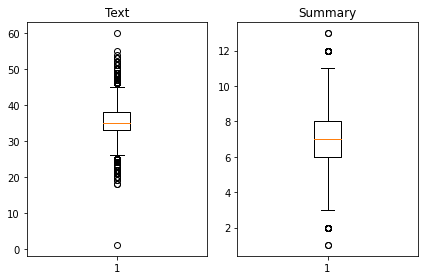

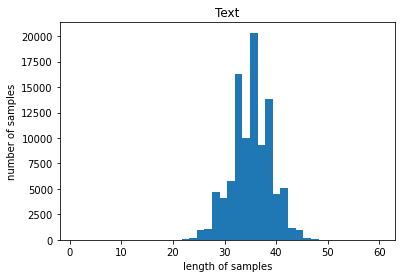

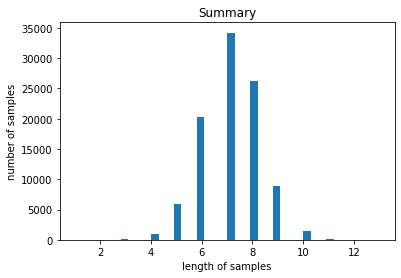

In [11]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
text_max_len = 40
text_min_len = 30

headlines_max_len = 8
headlines_min_len = 6

In [ ]:
def below_threshold_len(max_len, min_len, nested_list):
    cnt = 0
    for s in nested_list:
        #if(len(s.split()) <= max_len):
        if not (len(s.split()) <= max_len and len(s.split()) >= min_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하 %s 이상이 아닌 샘플의 비율: %s'%(max_len, min_len, (cnt / len(nested_list))))

In [14]:
below_threshold_len(text_max_len, text_min_len, data['text'])
below_threshold_len(headlines_max_len,  headlines_min_len, data['headlines'])

전체 샘플 중 길이가 40 이하 30 이상이 아닌 샘플의 비율: 0.9238320748772878
전체 샘플 중 길이가 8 이하 6 이상이 아닌 샘플의 비율: 0.8925925549537098


In [15]:
orgdata = data.copy() # 이후 data 조작 중 잘못됐을때 사용하기 위해 복사
data = data[data.apply(lambda x: len(x['text'].split()) <= text_max_len and len(x['headlines'].split()) <= headlines_max_len , axis=1)]
data = data[data.apply(lambda x: len(x['text'].split()) >= text_min_len and len(x['headlines'].split()) >= headlines_min_len , axis=1)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 81945


In [16]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken
6,india get lowest odi total new zealand,india recorded lowest odi total new zealand ge...,sostoken india get lowest odi total new zealand,india get lowest odi total new zealand eostoken
7,govt directs alok verma join work day retirement,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma join work day...,govt directs alok verma join work day retireme...
9,cong wins ramgarh bypoll rajasthan takes total...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll rajasthan ta...,cong wins ramgarh bypoll rajasthan takes total...


In [ ]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [18]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[16602 18352 48282 ... 56705 62392 57148]


In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [20]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 16389


In [21]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 65556
훈련 레이블의 개수 : 65556
테스트 데이터의 개수 : 16389
테스트 레이블의 개수 : 16389


##### 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [ ]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [23]:
threshold = 7 # 등장 빈도수의 th
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 63052
등장 빈도가 6번 이하인 희귀 단어의 수: 43023
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20029
단어 집합에서 희귀 단어의 비율: 68.23415593478398
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.8985045573936152


In [ ]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [25]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[349, 27, 1578, 392, 5660, 6611, 4114, 692, 332, 598, 718, 336, 1724, 637, 172, 158, 798, 718, 835, 1881, 213, 3184, 4114, 459, 6735, 718, 901, 5395, 417, 718, 4377, 317, 1663], [216, 1, 251, 3862, 11, 576, 1086, 1086, 303, 112, 2, 963, 296, 527, 1544, 2196, 1894, 4634, 35, 5, 490, 1419, 2009, 2883, 1894, 1], [1160, 14, 7270, 50, 5396, 1, 1160, 1052, 3, 4345, 114, 1670, 5396, 2, 1401, 1052, 776, 677, 305, 1401, 226, 1160, 9, 6, 4471, 945, 2139]]


In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [27]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27525
등장 빈도가 5번 이하인 희귀 단어의 수: 18220
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9305
단어 집합에서 희귀 단어의 비율: 66.19436875567666
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.7962219296391595


In [28]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 668, 422, 83, 729, 821], [1, 688, 1659, 622], [1, 851, 35], [1, 440, 273, 1348, 675], [1, 102, 255, 198, 23, 1122, 1624, 16]]
target
decoder  [[668, 422, 83, 729, 821, 2], [688, 1659, 622, 2], [851, 35, 2], [440, 273, 1348, 675, 2], [102, 255, 198, 23, 1122, 1624, 16, 2]]


In [29]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 218
삭제할 테스트 데이터의 개수 : 58
훈련 데이터의 개수 : 65338
훈련 레이블의 개수 : 65338
테스트 데이터의 개수 : 16331
테스트 레이블의 개수 : 16331


##### 패딩하기

In [ ]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

###  모델 설계하기

In [31]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [32]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [33]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

#### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
##### 어텐션 메커니즘

In [34]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련하기

In [35]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1) # 조기 종료 # patience : 검증 데이터의 손실이 줄어들지 않고 증가하는 현상

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
256/256 [==============================] - 29s 61ms/step - loss: 4.3415 - val_loss: 4.0610
Epoch 2/50
256/256 [==============================] - 14s 56ms/step - loss: 3.8462 - val_loss: 3.6999
Epoch 3/50
256/256 [==============================] - 15s 57ms/step - loss: 3.5615 - val_loss: 3.5006
Epoch 4/50
256/256 [==============================] - 15s 58ms/step - loss: 3.3444 - val_loss: 3.3160
Epoch 5/50
256/256 [==============================] - 15s 58ms/step - loss: 3.1809 - val_loss: 3.2052
Epoch 6/50
256/256 [==============================] - 15s 58ms/step - loss: 3.0481 - val_loss: 3.1272
Epoch 7/50
256/256 [==============================] - 15s 58ms/step - loss: 2.9315 - val_loss: 3.0447
Epoch 8/50
256/256 [==============================] - 15s 58ms/step - loss: 2.8290 - val_loss: 3.0023
Epoch 9/50
256/256 [==============================] - 15s 58ms/step - loss: 2.7376 - val_loss: 2.9315
Epoch 10/50
256/256 [==============================] - 15s 58ms/step - loss: 2.657

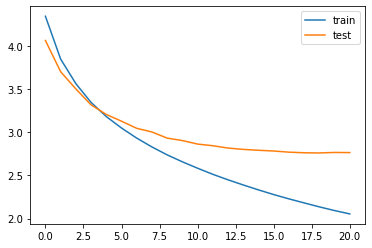

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

epoch이 진행될수록 loss는 점점 감소하며, 증 데이터의 손실이 줄어들지 않고 증가하는 현상 2회 발생하여 21epoch 이후 학습 조기 종료함

##### 인퍼런스 모델 구현

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [40]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

=3


In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            if tar_index_to_word[i] == 'sostoken' or tar_index_to_word[i] == 'eostoken':
                continue
            temp = temp + tar_index_to_word[i]+' '
    return temp


#### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
##### 모델 테스트 하기

In [42]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : central reserve police force said tuesday bus carrying amarnath pilgrims came attack terrorists violated security protocol bus pilgrims without police registered amarnath shrine board also pm security cover withdrawn 
실제 요약 : bus attacked terrorists security crpf 
예측 요약 :  crpf attack attack crpf


원문 : chennai super kings captain mahendra singh dhoni slammed second biggest six ipl smashing delhi daredevils fast bowler khan full toss distance metres monday year old went hit five knock rcb ab de villiers hit biggest six tournament 
실제 요약 : ms dhoni six nd biggest ipl 
예측 요약 :  dhoni csk captain ipl


원문 : maldives supreme court upheld result presidential election president lost opposition candidate ibrahim mohamed court rejected petition seeking result ruling failed prove elections initially conceded defeat called fresh elections later citing unfair elections 
실제 요약 : sc president poll defeat 
예측 요약 :  prez election vote election


원문 : infosys co founder nandan nilekani friday twe

예측 요약 :  microsoft working ai ceo


원문 : kerala sabarimala temple recorded highest ever collection crore pilgrimage season state tourism minister said tuesday temple witnessed increase crore collection season compared last season added state spent crore construction activities pilgrimage season said 
실제 요약 : sabarimala temple record crore 
예측 요약 :  sabarimala temple crore


원문 : year old man survived last year mass shooting las vegas killed among killed wednesday mass shooting california graduate thousand high school later joined navy many people killed mass shooting bar wednesday 
실제 요약 : shooting killed mass shooting 
예측 요약 :  killed injured shooting


원문 : samsung president ceo dj announced company make least million phones available first half also said met google ceo sundar pichai develop software interface phone phone official name yet added 
실제 요약 : samsung make least million phones 
예측 요약 :  samsung founders sell android


원문 : india fiscal deficit april january reached target 

#### Step 5. Summa을 이용해서 추출적 요약해보기

In [43]:
import requests
from summa.summarizer import summarize

In [54]:
for i in range(50, 60):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 : ", seq2summary(decoder_input_test[i]))
    print("추상적 예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("추출적 예측 요약 :", summarize(seq2text(encoder_input_test[i]), ratio=0.5))
#     print("예측 요약 :", summarize(seq2text(encoder_input_test[i]), words=50))
    print("\n")

원문 : central reserve police force said tuesday bus carrying amarnath pilgrims came attack terrorists violated security protocol bus pilgrims without police registered amarnath shrine board also pm security cover withdrawn 
실제 요약 :  bus attacked terrorists security crpf 
예측 요약 :  crpf attack attack crpf
예측 요약 : 


원문 : chennai super kings captain mahendra singh dhoni slammed second biggest six ipl smashing delhi daredevils fast bowler khan full toss distance metres monday year old went hit five knock rcb ab de villiers hit biggest six tournament 
실제 요약 :  ms dhoni six nd biggest ipl 
예측 요약 :  dhoni csk captain ipl
예측 요약 : 


원문 : maldives supreme court upheld result presidential election president lost opposition candidate ibrahim mohamed court rejected petition seeking result ruling failed prove elections initially conceded defeat called fresh elections later citing unfair elections 
실제 요약 :  sc president poll defeat 
예측 요약 :  prez election vote election
예측 요약 : 


원문 : infosys co foun

원문이 데이터 처리를 진행하면서 변경되어 진짜 원본을 reload 하여 추출적 요약 진행

In [61]:
data_org = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
for i in range(50, 100):
#     _text = seq2text(encoder_input_test[i])
    _text = data_org.iloc[i,1]
    print("원문 :", _text)
    print("실제 요약 : ", data_org.iloc[i,0])
    print("예측 요약 : ", summarize(_text, ratio=0.35)) # ratio안달면 결과 안나옴...
    print("\n")

원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
실제 요약 :  Yashwant Sinha demands probe into alleged fund diversion by DHFL
예측 요약 :  Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the seventh straig

같은 원문을 직접 비교해보고 싶었지만.... 찾기가 힘들어서 각 하나씩 문장을 가져오록 하겠습니다 

|종류|원문|실제요약|예측 요약|문법완성|핵심단어 측면|
|:----:|:-----:|:----:|:----:|:---:|:---:|
|추상적 요약|samsung president ceo dj announced company make least million phones available first half also said met google ceo sundar pichai develop software interface phone phone official name yet added |samsung make least million phones |samsung founders sell android|매우 미약|대체로 우수|
|추출적 요약|North Korea is "unlikely to completely give up its nuclear weapons and production capabilities", Director of US' National Intelligence, Daniel Coats, said. "North Korean leaders view nuclear arms as critical to regime survival," he added. His statements come despite North Korea's agreement with the US at the Singapore summit last year to denuclearise the Korean Peninsula. |N Korea unlikely to give up nuclear weapons: US intelligence chief|"North Korean leaders view nuclear arms as critical to regime survival," he added.|우수|우수|


|종류|특징|비고|
|:----:|:-----:|:---:|
|추상적 요약|마치 사람이 원문을 읽고 창의적으로 글을 쓰는 느낌|학습을 조금 더 잘하면 재밌는 결과 도출할 듯|
|추출적 요약|문장을 읽고 단어를 뽑아서 문장을 만드는 느낌||